In [1]:
from torch_geometric.datasets import Planetoid

citeseer_dataset = Planetoid(root = "./data", name = "CiteSeer")
cora_dataset = Planetoid(root = "./data", name = "Cora")
pubmed_dataset = Planetoid(root = "./data", name = "PubMed")

In [2]:
import torch_geometric.transforms as T


def pre_process(dataset):
    dataset.transform = T.NormalizeFeatures()
    return dataset

In [3]:
CORA = "Cora"
PUBMED = "PubMed"
CITESEER = "Citeseer"

name_to_dataset = dict({})
name_to_dataset[CORA] = pre_process(cora_dataset)
name_to_dataset[PUBMED] = pre_process(pubmed_dataset)
name_to_dataset[CITESEER] = pre_process(citeseer_dataset)

In [4]:
name_to_sets = dict({})

In [5]:
from torch_geometric.utils import add_self_loops

def add_set(set_name):
    global name_to_sets, name_to_dataset
    name_to_sets[set_name] = dict({})
    
    dataset = name_to_dataset[set_name]
    X =  dataset[0].x 
    y =  dataset[0].y 
    
    test =  dataset[0].test_mask
    train = dataset[0].train_mask 
    val =  dataset[0].val_mask
    
    edge_index = add_self_loops(dataset[0].edge_index)[0]

    name_to_sets[set_name]["X"] = X
    name_to_sets[set_name]["y"] = y
    name_to_sets[set_name]["test"] = test
    name_to_sets[set_name]["train"] = train
    name_to_sets[set_name]["val"] = val
    name_to_sets[set_name]["edge_index"] = edge_index

In [6]:
def create_sets():
    for set_name in name_to_dataset.keys():
        add_set(set_name)
create_sets()

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from AutoTune2 import AutoSearch
from hyperopt import fmin, tpe, hp,STATUS_OK, SparkTrials, space_eval 

penalty = ["l1","l2", "elasticnet"]
max_iter = [2**i for i in range(6, 13)] #6,16 before

lr_choices = {
    'penalty': penalty,
    'max_iter': max_iter,
    
}

space_lr = {
    **{key: hp.choice(key, value) for key, value in lr_choices.items()},
    'tol': hp.loguniform('tol', -11, -3),
    'C': hp.uniform('C', 0.0, 100),#20 before
    # 'l1_ratio': hp.uniform('l1_ratio', 0.0, 1.0)
}


def norm_user_function(kwargs):
    return  normalize(kwargs["original_features"] + kwargs["summed_neighbors"], p=2.0, dim = 1)
    
def user_function(kwargs):
    return  kwargs["original_features"] + kwargs["summed_neighbors"]
    
clfs = [LogisticRegression]
hops = [0,3,8]
clfs_space = dict({})
clfs_space["LogisticRegression"] = space_lr
attention_configs = [None,{'inter_layer_normalize': False,
                     'use_pseudo_attention':True,
                     'cosine_eps':.01,
                     'dropout_attn': None}, 
                     {'inter_layer_normalize': True,
                     'use_pseudo_attention':True,
                     'cosine_eps':.01,
                     'dropout_attn': None},
                     {'inter_layer_normalize': True,
                     'use_pseudo_attention':True,
                     'cosine_eps':.001,
                     'dropout_attn': None}]
user_functions = [norm_user_function, user_function]

searcher = AutoSearch(name_to_sets[PUBMED], max_evals=100, pred_metric = accuracy_score)
store = searcher.search(clfs, clfs_space, hops=[0,3,8])
# pubmed_store = search(CORA,clfs, hops, user_functions, clfs_space, attention_configs)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/01/08 00:54:54 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Because the requested parallelism was None or a non-positive value, parallelism will be set to (64), which is Spark's default parallelism (64), or 1, whichever is greater. We recommend setting parallelism explicitly to a positive value because the total of Spark task slots is subject to cluster sizing.
Traceback (most recent call last):                                              
  File "/home/dwalke/.local/lib/python3.10/site-packages/hyperopt/spark.py", line 467, in run_task_on_executor
    result = domain.evaluate(
  File "/home/dwalke/.local/lib/python3.10/site-packages/hyperopt/base.py", line 892, in evaluate
    rval = self.fn(pyll_rval)
  File "/home/dwalke/git/graph_aware_ml/AutoTune2.py", line 87, in object

  0%|          | 0/4 [00:00<?, ?it/s]

Because the requested parallelism was None or a non-positive value, parallelism will be set to (64), which is Spark's default parallelism (64), or 1, whichever is greater. We recommend setting parallelism explicitly to a positive value because the total of Spark task slots is subject to cluster sizing.
Traceback (most recent call last):) / 1][Stage 1201:>               (0 + 1) / 1]
  File "/home/dwalke/.local/lib/python3.10/site-packages/hyperopt/spark.py", line 467, in run_task_on_executor
    result = domain.evaluate(
  File "/home/dwalke/.local/lib/python3.10/site-packages/hyperopt/base.py", line 892, in evaluate
    rval = self.fn(pyll_rval)
  File "/home/dwalke/git/graph_aware_ml/AutoTune2.py", line 87, in objective
    framework.fit(auto_search.data.X, auto_search.data.edge_index,
  File "/home/dwalke/git/graph_aware_ml/EnsembleFramework.py", line 195, in fit
    clf.fit(aggregated_train_features.cpu().numpy(), y_train,**transformed_kwargs)
  File "/home/dwalke/.local/lib/python3

  0%|          | 0/4 [00:00<?, ?it/s]

Because the requested parallelism was None or a non-positive value, parallelism will be set to (64), which is Spark's default parallelism (64), or 1, whichever is greater. We recommend setting parallelism explicitly to a positive value because the total of Spark task slots is subject to cluster sizing.
Traceback (most recent call last):401:> (0 + 1) / 1][Stage 2402:> (0 + 1) / 1]1]
  File "/home/dwalke/.local/lib/python3.10/site-packages/hyperopt/spark.py", line 467, in run_task_on_executor
    result = domain.evaluate(
  File "/home/dwalke/.local/lib/python3.10/site-packages/hyperopt/base.py", line 892, in evaluate
    rval = self.fn(pyll_rval)
  File "/home/dwalke/git/graph_aware_ml/AutoTune2.py", line 87, in objective
    framework.fit(auto_search.data.X, auto_search.data.edge_index,
  File "/home/dwalke/git/graph_aware_ml/EnsembleFramework.py", line 195, in fit
    clf.fit(aggregated_train_features.cpu().numpy(), y_train,**transformed_kwargs)
  File "/home/dwalke/.local/lib/python3

In [33]:
store

{'LogisticRegression': {0: {'train_acc': 1.0,
   'val_acc': 0.746,
   'test_acc': 0.742,
   'model': LogisticRegression(C=27.411789779092654, max_iter=128, tol=0.039938733839705025),
   'user_function': <function AutoTune2.upd_user_function(kwargs)>,
   'attention_config': {'inter_layer_normalize': True,
    'use_pseudo_attention': True,
    'cosine_eps': 0.001,
    'dropout_attn': None}},
  3: {'train_acc': 0.9833333333333333,
   'val_acc': 0.81,
   'test_acc': 0.801,
   'model': LogisticRegression(C=2.5987332809829566, max_iter=128,
                      tol=4.970479192374648e-05),
   'user_function': <function AutoTune2.norm_user_function(kwargs)>,
   'attention_config': {'inter_layer_normalize': False,
    'use_pseudo_attention': True,
    'cosine_eps': 0.01,
    'dropout_attn': None}},
  8: {'train_acc': 0.9833333333333333,
   'val_acc': 0.826,
   'test_acc': 0.793,
   'model': LogisticRegression(C=10.643722334010308, max_iter=512,
                      tol=9.444389107968778e-05),

In [9]:
from AutoTune2 import upd_user_function, norm_user_function
from sklearn.linear_model import LogisticRegression
store = {'LogisticRegression': {0: {'train_acc': 0.9833333333333333,
   'val_acc': 0.742,
   'test_acc': 0.737,
   'model': LogisticRegression(C=19.012946053218332, max_iter=4096,
                      tol=0.011693958862167635),
   'user_function': upd_user_function,
   'attention_config': {'inter_layer_normalize': True,
    'use_pseudo_attention': True,
    'cosine_eps': 0.001,
    'dropout_attn': None}},
  3: {'train_acc': 0.9833333333333333,
   'val_acc': 0.812,
   'test_acc': 0.802,
   'model': LogisticRegression(C=2.3417904147486635, max_iter=4096,
                      tol=1.877242326314165e-05),
   'user_function': norm_user_function,
   'attention_config': {'inter_layer_normalize': False,
    'use_pseudo_attention': True,
    'cosine_eps': 0.01,
    'dropout_attn': None}},
  8: {'train_acc': 0.9666666666666667,
   'val_acc': 0.826,
   'test_acc': 0.793,
   'model': LogisticRegression(C=8.816857543671555, max_iter=256, tol=0.0003864950814262107),
   'user_function': norm_user_function,
   'attention_config': None}}}

In [9]:
from AutoTune2 import upd_user_function, norm_user_function
from sklearn.linear_model import LogisticRegression
store = {'LogisticRegression': {0: {'train_acc': 1.0,
   'val_acc': 0.746,
   'test_acc': 0.742,
   'model': LogisticRegression(C=27.411789779092654, max_iter=128, tol=0.039938733839705025),
   'user_function': upd_user_function,
   'attention_config': {'inter_layer_normalize': True,
    'use_pseudo_attention': True,
    'cosine_eps': 0.001,
    'dropout_attn': None}},
  3: {'train_acc': 0.9833333333333333,
   'val_acc': 0.81,
   'test_acc': 0.801,
   'model': LogisticRegression(C=2.5987332809829566, max_iter=128,
                      tol=4.970479192374648e-05),
   'user_function': norm_user_function,
   'attention_config': {'inter_layer_normalize': False,
    'use_pseudo_attention': True,
    'cosine_eps': 0.01,
    'dropout_attn': None}},
  8: {'train_acc': 0.9833333333333333,
   'val_acc': 0.826,
   'test_acc': 0.793,
   'model': LogisticRegression(C=10.643722334010308, max_iter=512,
                      tol=9.444389107968778e-05),
   'user_function': norm_user_function,
   'attention_config': None}}}

In [10]:
from EnsembleFramework import Framework

hops_list=[3]
name_to_model = dict({})
def fit_dataset(set_name,user_functions, hops_list= hops_list, clfs = [], attention_configs= []):
    dataset = name_to_sets[set_name]
    y = dataset["y"]
    
    framework = Framework(user_functions, 
                     hops_list=hops_list, ## to obtain best for local neighborhood
                     clfs=clfs,
                     gpu_idx=0,
                     handle_nan=0.0,
                    attention_configs=attention_configs)
    vals = framework.get_features(dataset["X"], dataset["edge_index"], dataset["val"])
    vals = [val.cpu() for val in vals]
    print([clf.__class__.__name__ for clf in clfs])
    kwargs_list=[{"eval_set":[(vals[i], y[dataset["val"]])], "early_stopping_rounds":5} if clf.__class__.__name__ == 'XGBClassifier' else {} for i, clf in enumerate(clfs)]
    print(kwargs_list)
    framework.fit(dataset["X"], dataset["edge_index"], y, dataset["train"], kwargs_list)
    name_to_model[set_name] = framework
    return framework

In [11]:
from sklearn.metrics import accuracy_score

def predict_dataset(set_name,framework):
    dataset = name_to_sets[set_name]
    
    y = dataset["y"]
    framework = name_to_model[set_name]
    pred = framework.predict(dataset["X"], dataset["edge_index"], dataset["test"]) 
    pred_val = framework.predict(dataset["X"], dataset["edge_index"], dataset["val"]) 
    y_test = y[dataset["test"]]
    y_val = y[dataset["val"]]
    print(set_name)
    print(accuracy_score(y_val, pred_val))
    print(accuracy_score(y_test, pred))

In [18]:
store = store
user_functions = [ store["LogisticRegression"][0]["user_function"],store["LogisticRegression"][3]["user_function"], store["LogisticRegression"][8]["user_function"]]
clfs = [store["LogisticRegression"][0]["model"],store["LogisticRegression"][3]["model"], store["LogisticRegression"][8]["model"]]
attention_configs = [store["LogisticRegression"][0]["attention_config"], store["LogisticRegression"][3]["attention_config"], store["LogisticRegression"][8]["attention_config"]]

# user_functions = [store["LogisticRegression"][3]["user_function"]]
# clfs = [store["LogisticRegression"][3]["model"]]
# attention_configs = [store["LogisticRegression"][3]["attention_config"]]
start = time.time()
framework = fit_dataset(PUBMED, user_functions=user_functions, hops_list= [0, 3, 8], clfs = clfs, attention_configs= attention_configs)
predict_dataset(PUBMED, framework)
start - time.time()

['LogisticRegression', 'LogisticRegression', 'LogisticRegression']
[{}, {}, {}]
PubMed
0.814
0.803


-3.086512565612793

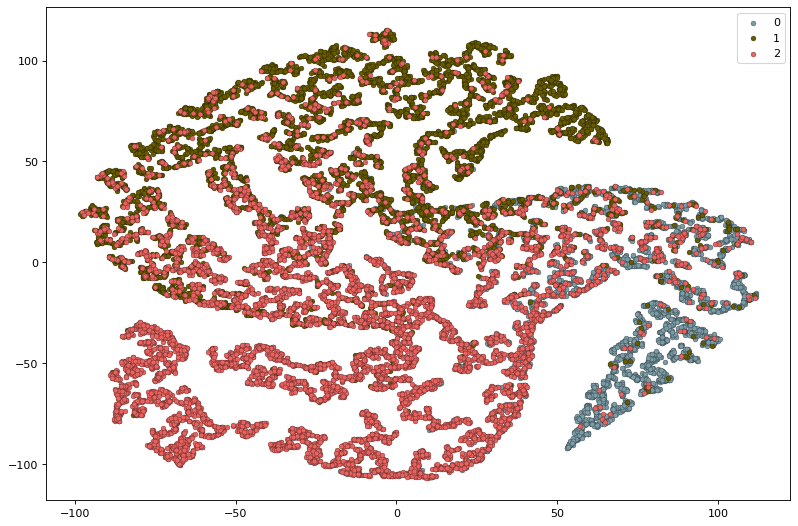

In [13]:
import torch
dataset = name_to_sets[PUBMED]
framework.plot_tsne(dataset["X"], dataset["edge_index"],dataset["y"],torch.ones(dataset["X"].shape[0]).type(torch.bool))

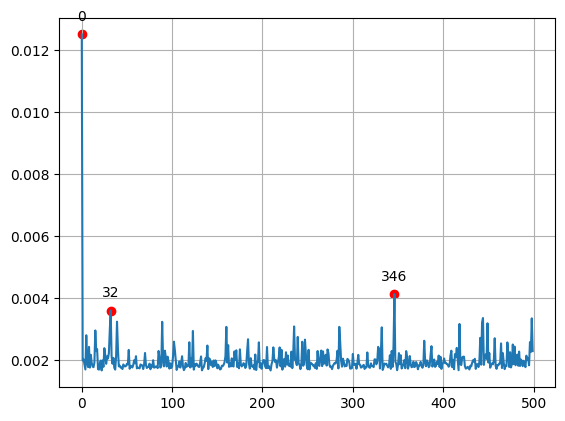

In [17]:
framework.plot_feature_importances()

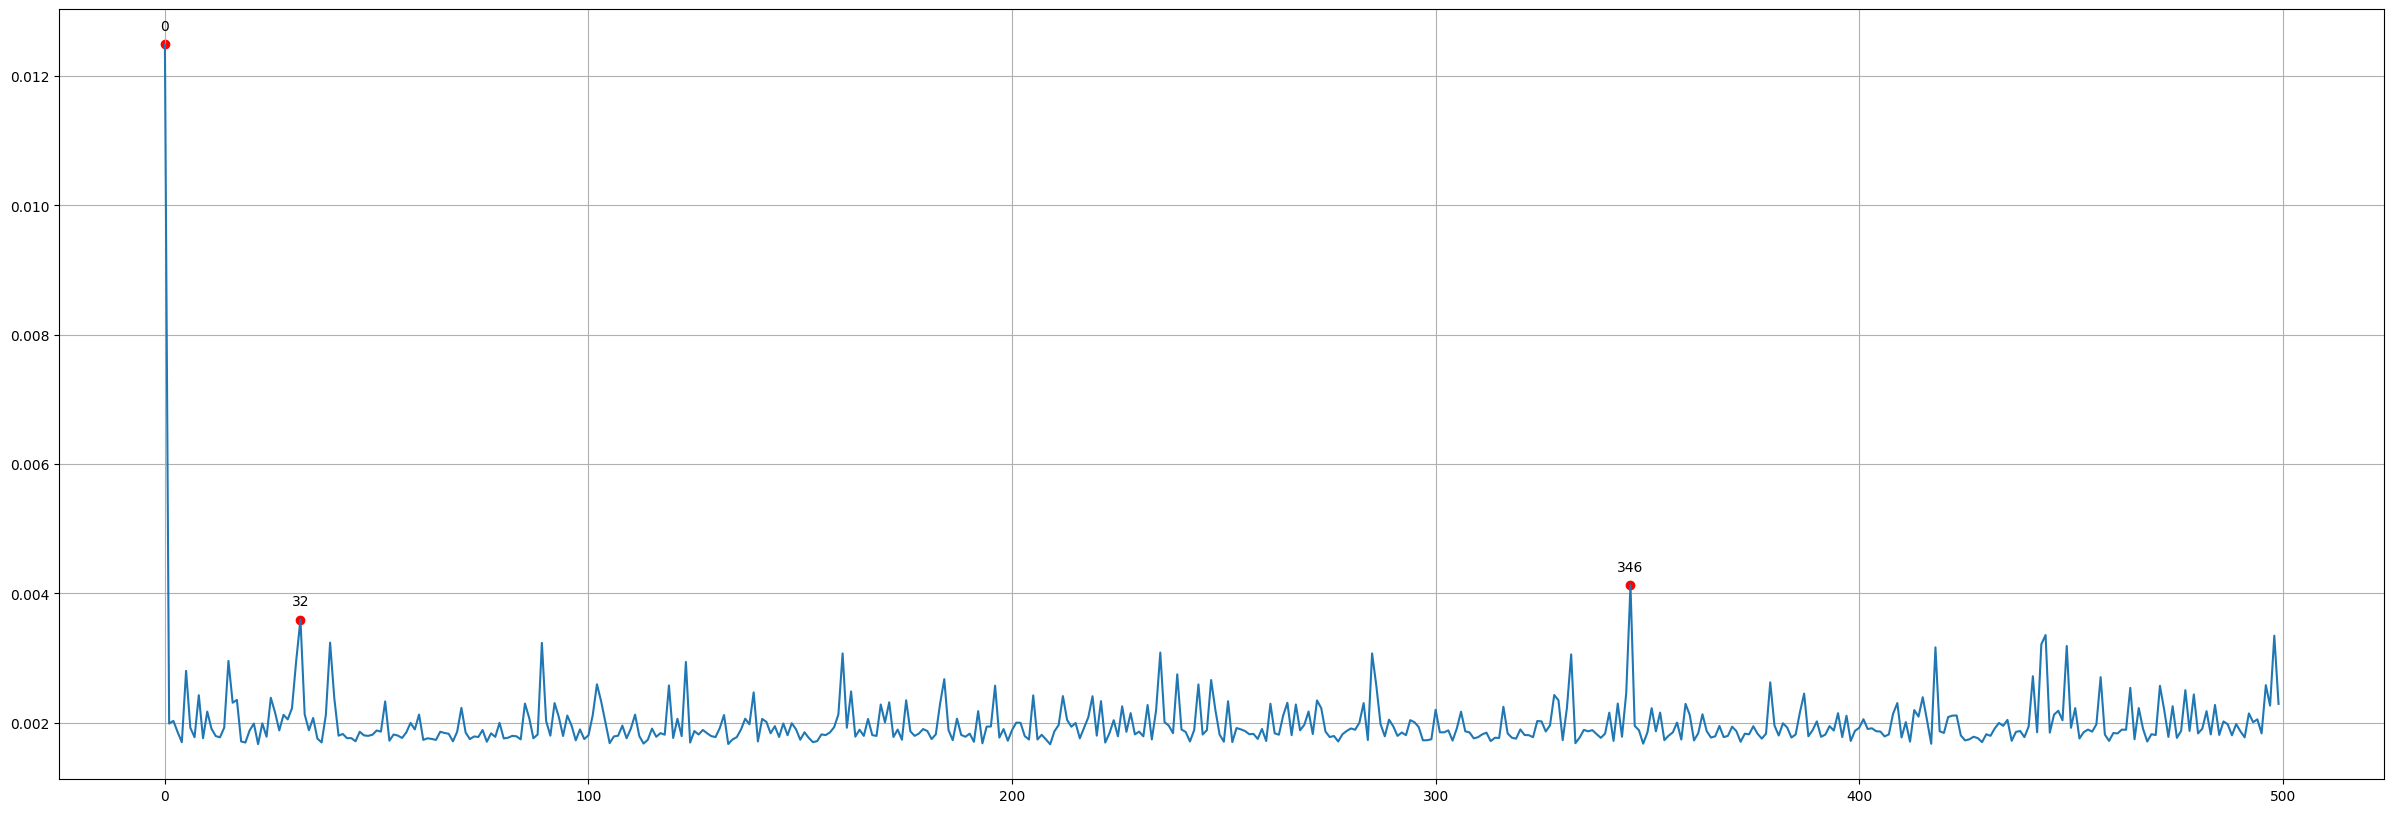

In [29]:
import matplotlib.pyplot as plt
dataset = name_to_sets[PUBMED]
framework.set_dataset(dataset)
fig, ax = plt.subplots()
fig.set_figwidth(30) 
fig.set_figheight(10) 
framework.plot_feature_importances(mark_top_n_peaks = 3)